In [23]:
import torch
import torchvision

import os
import cv2
import numpy as np
from PIL import Image
import skimage
import random

import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import models

from tqdm import tqdm

import matplotlib.pyplot as plt
from collections import OrderedDict

device="cpu"

%pip install torchgeometry

from torchgeometry.losses import ssim
from IPython.display import clear_output

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceloss, self).init()
    def forward(self,pred, target):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)

       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [4]:
class SoRa(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True, reg_coef=0.2):
        super(SoRa, self).__init__()
        self.reg_coef = reg_coef
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.fc_layer = nn.Linear(in_channels, out_channels, bias=bias)
        self.sora_mode = False
        self.W1 = None
        self.W2 = None
        self.g = None

    def activate(self, max_rank):
        self.sora_mode = True
        self.W1 = nn.Linear(self.in_channels, max_rank, bias=False)
        self.W2 = nn.Linear(max_rank, self.out_channels, bias=False)
        self.W2.weight = torch.nn.Parameter(torch.zeros_like(self.W2.weight), requires_grad=True)
        self.g = torch.nn.Parameter(torch.ones(max_rank), requires_grad=True)
        self.fc_layer.weight.requires_grad = False

    def forward(self, x):
        res = self.fc_layer(x)
        if self.sora_mode:
            res += self.W2(self.g * self.W1(x))
        return res

    def gate(self, lr):
        assert self.sora_mode == True
        self.g.data =  torch.sgn(self.g) * torch.clamp(torch.abs(self.g) - lr * self.reg_coef, min=0)

    def freeze(self):
        assert self.sora_mode == True
        self.g.detach()
        self.W2.weight.detach()
        self.W1.weight.detach()
        self.fc_layer.weight = torch.nn.Parameter(self.fc_layer.weight + (self.g * self.W2.weight) @ self.W1.weight)
        self.sora_mode = False
        self.W1 = None
        self.W2 = None
        self.g = None


class UNet(nn.Module):

    def __init__(self, reg_coef=0.2):
        super(UNet, self).__init__()

        features = 4
        self.encoder1 = UNet._block(3, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder5 = UNet._block(features * 8, features * 16, name="enc5")
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder6 = UNet._block(features * 16, features * 16, name="enc5")
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.sora_modules = [SoRa(1024, 1024, bias=True, reg_coef=reg_coef)]
        self.flat = nn.Flatten()
        self.bottleneck = nn.Sequential(OrderedDict([("bottleneckfc", self.sora_modules[0]), ("bottleneckrelu", nn.ReLU())]))

        self.unflat = nn.Unflatten(1, (64, 4, 4))
        
        self.upconv6 = nn.ConvTranspose2d(
            features * 16, features * 16, kernel_size=2, stride=2
        )
        self.decoder6 = UNet._block((features * 16) * 2, features * 16, name="dec5")

        self.upconv5 = nn.ConvTranspose2d(
            features * 16, features * 16, kernel_size=2, stride=2
        )
        self.decoder5 = UNet._block((features * 16) * 2, features * 8, name="dec5")

        self.upconv4 = nn.ConvTranspose2d(
            features * 8, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=1, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        enc5 = self.encoder5(self.pool4(enc4))
        enc6 = self.encoder6(self.pool5(enc5))

        bottleneck = self.flat(self.pool6(enc6))

        bottleneck = self.bottleneck(bottleneck)

        bottleneck = self.unflat(bottleneck)
        
        dec6 = self.upconv6(bottleneck)
        dec6 = torch.cat((dec6, enc6), dim=1)
        dec6 = self.decoder6(dec6)

        dec5 = self.upconv5(dec6)
        dec5 = torch.cat((dec5, enc5), dim=1)
        dec5 = self.decoder5(dec5)

        dec4 = self.upconv4(dec5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

def get_score(pred, labels):
    diff = torch.abs(pred - labels)
    score = torch.sum(1 - diff) / (torch.sum(1 + diff) + 1e-10)
    return score

In [5]:
model = torch.load("model_cv/egohand_model.pt")

In [6]:
model

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_

In [13]:
class getDataset(Dataset):
    def __init__(self, name, indexes=None):
        self.image_path = f"data/{name}/images/"
        self.mask_path = f"data/{name}/masks/"
        self.files = os.listdir(self.image_path)

        if indexes is None:
            indexes = np.arange(len(self.files))

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            transforms.GaussianBlur(5, sigma=(0.2, 0.2))
        ])

        self.images = []
        self.masks = []

        for ind in indexes:
            file = self.files[ind]
            new_image = skimage.io.imread(self.image_path + file).astype(float)
            self.images.append(self.transform(new_image).float())
            new_mask = skimage.io.imread(self.mask_path + file).astype(float) / 255
            self.masks.append(transforms.ToTensor()(new_mask).float())

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        return self.images[index], self.masks[index]

In [11]:
from sklearn.model_selection import train_test_split

train_indexes, test_indexes = train_test_split(np.arange(662), test_size=0.2, shuffle=True)

In [14]:
dataset = getDataset("GTEA", train_indexes)
test_dataset = getDataset("GTEA", test_indexes)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

In [35]:
def sora_train(model, optimizer, scheduler, train_loader, criterion, val_loader, n_epochs):

    train_losses = []
    val_losses = []

    train_acc = []
    test_acc = []

    for epoch in range(n_epochs):
        model.train()
        train_losses_per_epoch = []

        count = 0
        acc = 0

        for batch in tqdm(train_loader):
            #torch.cuda.empty_cache()
            X_batch, y_batch = batch
            optimizer.zero_grad()
            y_pred = model(X_batch.to(device))
            loss = criterion(y_pred, y_batch.to(device))
            loss.backward()
            optimizer.step()
            learning_rate = optimizer.param_groups[0]['lr']
            model.sora_modules[0].gate(learning_rate)
            train_losses_per_epoch.append(loss.item())
            acc += len(batch) * get_score(y_pred.to("cpu"), y_batch).item()
            count += len(batch)

        acc = acc / count

        train_acc.append(acc)

        train_losses.append(np.mean(train_losses_per_epoch))
        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            count = 0
            acc = 0
            for batch in val_loader:
                #torch.cuda.empty_cache()
                X_batch, y_batch = batch
                y_pred = model(X_batch.to(device))
                loss = criterion(y_pred, y_batch.to(device))
                val_losses_per_epoch.append(loss.item())
                acc += len(batch) * get_score(y_pred.to("cpu"), y_batch).item()
                count += len(batch)
            acc = acc / count
            test_acc.append(acc)

        val_losses.append(np.mean(val_losses_per_epoch))
        scheduler.step(val_losses[epoch])
        clear_output(wait=True)

        fig, ax = plt.subplots(1, 2, figsize=[12, 5])
        ax[0].grid()
        ax[0].set_xlabel("epoch")
        ax[0].set_ylabel("loss val")
        ax[0].plot(train_losses, label="train loss")
        ax[0].plot(val_losses, label="test loss")
        ax[0].legend()
        ax[1].grid()
        ax[1].set_xlabel("epoch")
        ax[1].set_ylabel("acc val")
        ax[1].plot(train_acc, label="train acc")
        ax[1].plot(test_acc, label="test acc")
        ax[1].legend()
        plt.show()

    return train_losses, val_losses

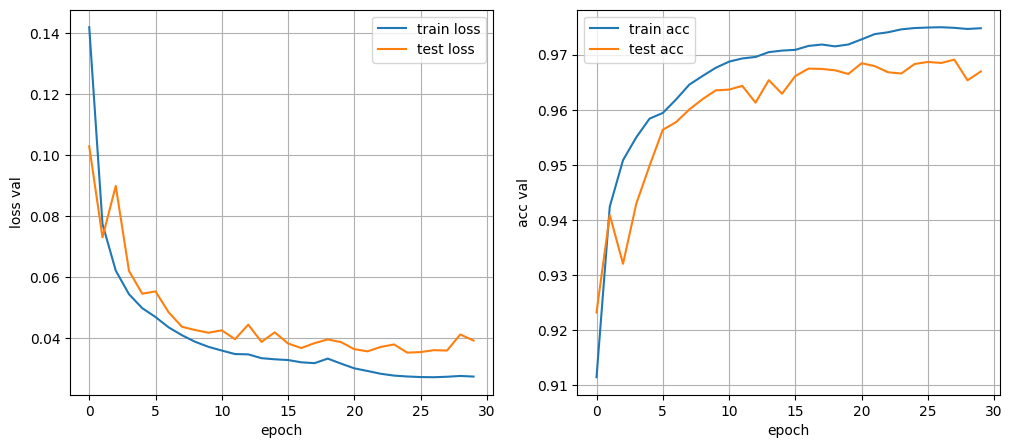

In [36]:
model_1 = torch.load("model_cv/egohand_model.pt")
model_1.reg_coef = 0.1
model_1.to(device)

model_1.sora_modules[0].activate(max_rank=40)

n_epochs = 30
optimizer = torch.optim.Adam(model_1.parameters(), lr= 0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True, min_lr=1e-6)
criterion = diceloss()

history_1 = sora_train(model_1, optimizer, scheduler, train_loader, criterion, test_loader, n_epochs)

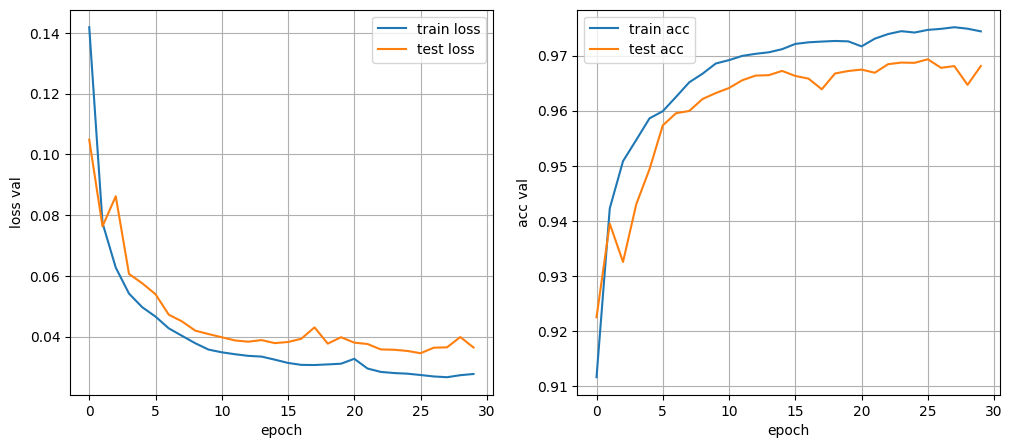

In [37]:
model_5 = torch.load("model_cv/egohand_model.pt")
model_5.reg_coef = 0.5
model_5.to(device)

model_5.sora_modules[0].activate(max_rank=40)

n_epochs = 30
optimizer = torch.optim.Adam(model_5.parameters(), lr= 0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True, min_lr=1e-6)
criterion = diceloss()

history_5 = sora_train(model_5, optimizer, scheduler, train_loader, criterion, test_loader, n_epochs)

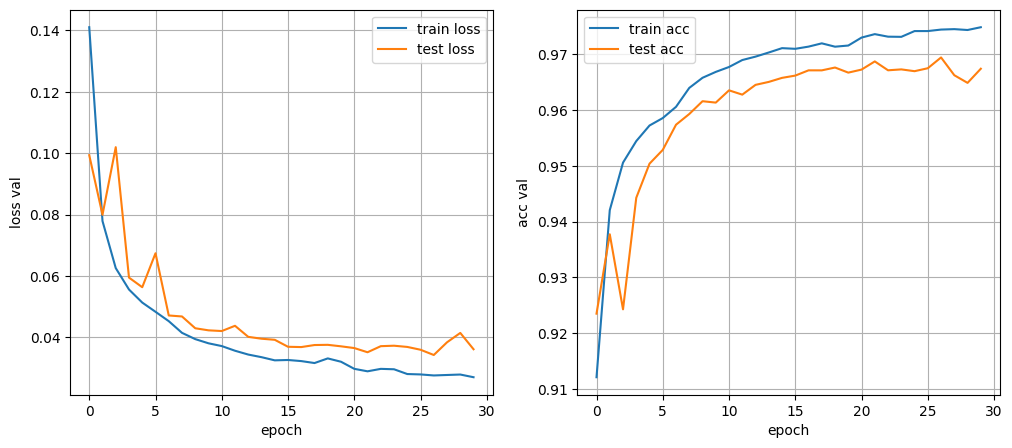

In [38]:
model_01 = torch.load("model_cv/egohand_model.pt")
model_01.reg_coef = 0.01
model_01.to(device)

model_01.sora_modules[0].activate(max_rank=40)

n_epochs = 30
optimizer = torch.optim.Adam(model_01.parameters(), lr= 0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True, min_lr=1e-6)
criterion = diceloss()

history_01 = sora_train(model_01, optimizer, scheduler, train_loader, criterion, test_loader, n_epochs)

Пиковая нагрузка на ОЗУ - 2.500 гб.

In [47]:
print(model_01.sora_modules[0].g)

print(torch.sum(model_01.sora_modules[0].g.abs() < 1e-5 ))

Parameter containing:
tensor([-0.0000, 0.0000, -0.0000, -0.0000, 0.2651, 0.0000, -0.0000, -0.0000, -0.0000,
        0.0000, 0.2123, -0.0000, 0.0000, -0.0000, -0.0000, 0.0000, -0.0000, 0.0000,
        -0.0000, -0.0000, 0.0000, -0.0000, 0.0000, 0.7429, 0.5286, 0.9301, 0.0000,
        0.1195, 0.0000, -0.0000, -0.0000, -0.0000, 0.8579, 0.0000, -0.0000, 0.0000,
        0.7377, -0.0000, -0.0000, -0.0000], requires_grad=True)
tensor(32)


In [46]:
print(model_5.sora_modules[0].g)

print(torch.sum(model_5.sora_modules[0].g.abs() < 1e-5 ))

Parameter containing:
tensor([ 7.1033e-03,  7.5736e-03,  3.0939e-04,  8.3093e-02,  1.6442e-01,
         5.6370e-03,  0.0000e+00,  1.2049e+00, -4.2106e-02,  1.1882e-02,
         9.9586e-01,  6.2093e-03,  5.9781e-03,  3.9275e-03,  9.5996e-03,
         1.6069e-02,  1.0798e-02,  5.7192e-03,  1.8927e-02,  6.6458e-01,
         8.5832e-01,  1.9166e-02,  6.4283e-01,  5.7877e-03,  9.0780e-03,
        -0.0000e+00,  2.7536e-01,  4.1325e-03,  6.1521e-01,  7.5363e-03,
         1.5386e-01,  8.4725e-01,  0.0000e+00,  7.6927e-03,  6.0067e-03,
         5.5830e-03,  6.1564e-03,  7.1730e-03,  9.3021e-03,  7.0348e-01],
       requires_grad=True)
tensor(3)


In [48]:
print(model_1.sora_modules[0].g)

print(torch.sum(model_1.sora_modules[0].g.abs() < 1e-5 ))

Parameter containing:
tensor([1.9720e-02, -0.0000e+00, 3.8899e-03, 1.1584e-02, 4.9326e-03, 8.0216e-01,
        0.0000e+00, 4.3812e-02, 0.0000e+00, 1.3305e-01, 9.8689e-01, 3.6058e-02,
        0.0000e+00, -0.0000e+00, 3.8865e-02, 3.5084e-02, 1.9294e-02, 1.5150e-01,
        1.2098e-02, 1.0466e+00, 2.1182e-01, 6.3510e-01, 2.3581e-03, 4.1356e-02,
        7.0968e-01, 1.0524e+00, -0.0000e+00, 2.0666e-02, 1.0714e-02, 1.9489e-02,
        -0.0000e+00, 1.8349e-03, 6.6730e-03, 7.0847e-01, -0.0000e+00, 2.6200e-02,
        0.0000e+00, 1.0481e-01, -0.0000e+00, 6.7693e-04], requires_grad=True)
tensor(10)


In [52]:
def train(model, optimizer, scheduler, train_loader, criterion, val_loader, n_epochs):

    train_losses = []
    val_losses = []

    train_acc = []
    test_acc = []

    for epoch in range(n_epochs):
        model.train()
        train_losses_per_epoch = []

        count = 0
        acc = 0

        for batch in tqdm(train_loader):
            torch.cuda.empty_cache()
            X_batch, y_batch = batch
            optimizer.zero_grad()
            y_pred = model(X_batch.to(device))
            loss = criterion(y_pred, y_batch.to(device))
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())
            acc += len(batch) * get_score(y_pred.to("cpu"), y_batch).item()
            count += len(batch)

        acc = acc / count

        train_acc.append(acc)

        train_losses.append(np.mean(train_losses_per_epoch))
        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            count = 0
            acc = 0
            for batch in val_loader:
                torch.cuda.empty_cache()
                X_batch, y_batch = batch
                y_pred = model(X_batch.to(device))
                loss = criterion(y_pred, y_batch.to(device))
                val_losses_per_epoch.append(loss.item())
                acc += len(batch) * get_score(y_pred.to("cpu"), y_batch).item()
                count += len(batch)
            acc = acc / count
            test_acc.append(acc)

        val_losses.append(np.mean(val_losses_per_epoch))
        scheduler.step(val_losses[epoch])
        clear_output(wait=True)

        fig, ax = plt.subplots(1, 2, figsize=[12, 5])
        ax[0].grid()
        ax[0].set_xlabel("epoch")
        ax[0].set_ylabel("loss val")
        ax[0].plot(train_losses, label="train loss")
        ax[0].plot(val_losses, label="test loss")
        ax[0].legend()
        ax[1].grid()
        ax[1].set_xlabel("epoch")
        ax[1].set_ylabel("acc val")
        ax[1].plot(train_acc, label="train acc")
        ax[1].plot(test_acc, label="test acc")
        ax[1].legend()
        plt.show()

    return train_losses, val_losses

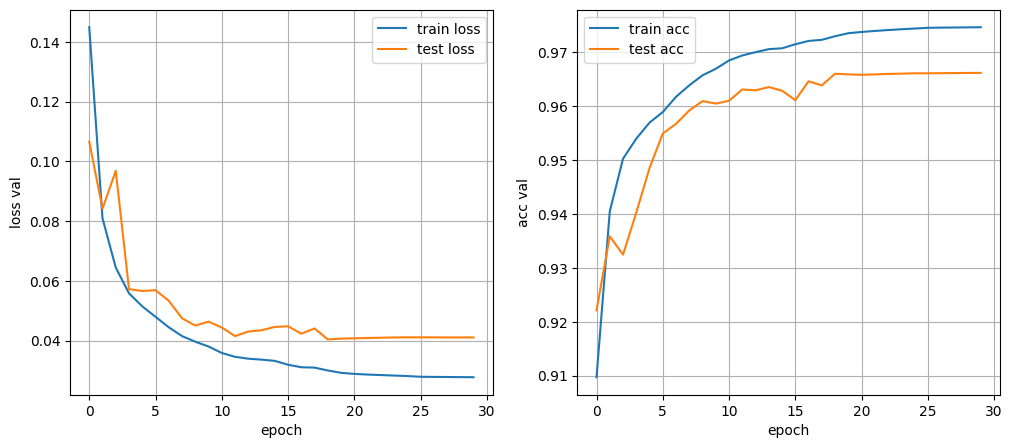

In [53]:
model = torch.load("model_cv/egohand_model.pt")

n_epochs = 30
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True, min_lr=1e-6)
criterion = diceloss()

history = train(model, optimizer, scheduler, train_loader, criterion, test_loader, n_epochs)

In [61]:
counter = 0
for param in model.parameters():
    counter += np.prod(param.size())
counter

1431533

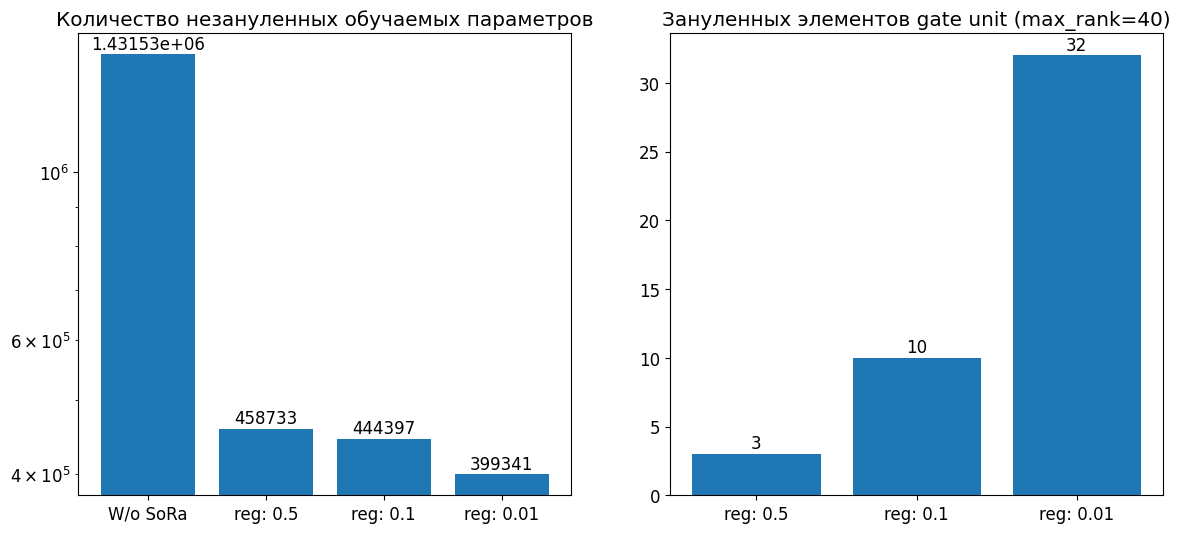

In [103]:
plt.rcParams.update({'font.size': 12})

labels = ["W/o SoRa", "reg: 0.5",  "reg: 0.1",  "reg: 0.01"]
heights = [counter, counter - 1024 * (1024 - 2 * 37), counter - 1024 * (1024 - 2 * 30), counter - 1024 * (1024 - 2 * 8)]
fig, ax = plt.subplots(1, 2, figsize=[14, 6])
bar_obj = ax[0].bar(labels, heights, label=heights)
ax[0].set_yscale("log")
ax[0].set_title("Количество незануленных обучаемых параметров")
ax[0].bar_label(bar_obj, padding=1)

ax[1].set_title("Зануленных элементов gate unit (max_rank=40)")
labels = ["reg: 0.5",  "reg: 0.1",  "reg: 0.01"]
heights = [3, 10, 32]
bar_obj = ax[1].bar(labels, heights)
ax[1].bar_label(bar_obj, padding=1)
plt.show()

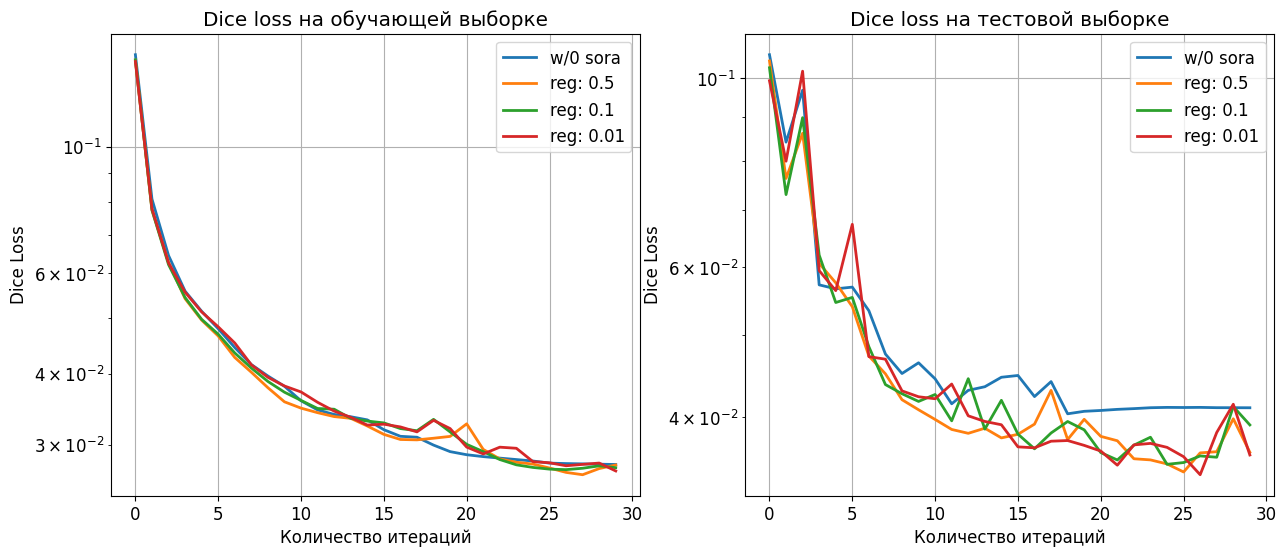

In [92]:
fig, ax = plt.subplots(1, 2, figsize=[15, 6])

ax[1].set_title("Dice loss на тестовой выборке")
ax[1].set_yscale("log")
ax[1].plot(history[1], linewidth=2, label="w/0 sora")
ax[1].plot(history_5[1], linewidth=2, label="reg: 0.5")
ax[1].plot(history_1[1], linewidth=2, label="reg: 0.1")
ax[1].plot(history_01[1], linewidth=2, label="reg: 0.01")
ax[1].set_xlabel("Количество итераций")
ax[1].set_ylabel("Dice Loss")
ax[1].legend()
ax[1].grid()

ax[0].set_title("Dice loss на обучающей выборке")
ax[0].set_yscale("log")
ax[0].plot(history[0], linewidth=2, label="w/0 sora")
ax[0].plot(history_5[0], linewidth=2, label="reg: 0.5")
ax[0].plot(history_1[0], linewidth=2, label="reg: 0.1")
ax[0].plot(history_01[0], linewidth=2, label="reg: 0.01")
ax[0].set_xlabel("Количество итераций")
ax[0].set_ylabel("Dice Loss")
ax[0].legend()
ax[0].grid()
plt.show()